# Нахождение уровней энергии частицы и функции распределения в потенциале вида $U(x) = -\frac{V_0}{ch^2{\alpha x}}$ (в нашем случае $V_0 = 2, \alpha = 1$)

# Импортируем необходимые библиотеки

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import mplcyberpunk
from sympy import *

## Выставим стиль для графиков

In [2]:
plt.style.use("cyberpunk")

# Уровни энергии это собственные значения уравнения Шрёдингера с соответствующим потенциалом с краевой задачей:
$$\cases{\frac{\partial^2 \psi(x)}{\partial x^2} + (E - U(x))\psi(x) = 0 \\ \psi(-\infty) = \psi(+\infty) = 0}$$

# Сделаем замену, $\xi = tanh(\alpha x)$, тогда граничные условия преобразуются:
$$\psi(x) = 0, x \rightarrow \pm\infty \\
\psi(\xi) = 0, \xi \rightarrow \pm1 $$
# И соответственно для уравнения Шрёдингера:
$$\frac{\partial^2 \psi(x)}{\partial x ^2} = \alpha^2 \left(1 - \xi^2\right)\left(\left(1-\xi^2\right) \frac{\partial^2 \psi(\xi)}{\partial \xi ^2} - 2 \xi \frac{\partial \psi(\xi)}{\partial \xi}\right) \\
U(\xi) = -V_0 (1 - \xi^2)$$
# Итогово приобретает вид для нашего случая:
$$\cases{\frac{\partial^2 \psi(\xi)}{\partial \xi ^2} - \frac{2 \xi}{1 - \xi^2} \frac{\partial \psi(\xi)}{\partial \xi} + \left(\frac{E}{\alpha^2\left(1 - \xi^2\right)^2} + \frac{V_0}{\alpha^2(1 - \xi^2)}\right)\psi(\xi) = 0 \\ \psi(-1) = \psi(+1) = 0}$$

# Перепишем для метода стрельбы:
$$\cases{ y' = U\\ U' = \frac{2 \xi}{1 - \xi^2} U - \left(\frac{E}{\alpha^2 \left(1 - \xi^2\right)^2} + \frac{V_0}{\alpha^2(1 - \xi^2)}\right)y}$$

In [3]:
def Runge_Kutta4GetLast (Func, initialT, initialСondition, numOfIterations, h):
    solution = initialСondition
    t = initialT
    
    for i in range(numOfIterations):
        k1 = Func(t, solution)
        k2 = Func(t + h / 2, solution + h / 2 * k1)
        k3 = Func(t + h / 2, solution + h / 2 * k2)
        k4 = Func(t + h, solution + h * k3)
        t += h
        solution = solution + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
    return solution

def ShootingEigenShrodinger (v_0 = 2, alpha_0 = 1, accuracy=0.001):
    step = 0.001
    var('x, y, u, E, V_0, alpha')
    f =  Array([u, 2*x/(1-x**2) * u - (E/(alpha**2)/(1-x**2)**2 + V_0/(alpha**2)/(1-x**2))*y])
    f = f.subs(V_0, v_0).subs(alpha, alpha_0)
    
    numParams = 20
    param = np.linspace(-v_0, 0, numParams)
    
    beginCond = [np.array([1, 0]), np.array([0, 1])]
    bordersForAccurateCalculations = []

    for cond in beginCond:
        idx = 0
        lessEnergy = float('nan')
        greaterEnergy = float('nan')
        flag = 0
        while (math.isnan(lessEnergy) or math.isnan(greaterEnergy)):
            func = lambdify((x,[y,u]), f.subs(E, param[idx]), 'numpy')
            solYsecond = Runge_Kutta4GetLast(func, 0.0, cond, int(1/step), step)[0]
            if (solYsecond < 0):
                lessEnergy = param[idx]
                if flag == 1:
                    bordersForAccurateCalculations.append([cond, [lessEnergy, greaterEnergy]])
                    greaterEnergy = float('nan')
                flag = -1
            if (solYsecond > 0):
                greaterEnergy = param[idx]
                if flag == -1:
                    bordersForAccurateCalculations.append([cond, [lessEnergy, greaterEnergy]])
                    lessEnergy = float('nan')
                flag = 1
            idx += 1
            if (idx >= numParams):
                break
    eigen = []
    for condition in bordersForAccurateCalculations:
        cond, [lessParam, greaterParam] = condition
        solYsecond = 1 # for restart calc on next iter
        while (abs(solYsecond) >= accuracy):
            middleParam = (greaterParam + lessParam) / 2
            func = lambdify((x,[y,u]), f.subs(E, middleParam), 'numpy')
            solYsecond = Runge_Kutta4GetLast(func, 0.0, cond, int(1 / step), step)[0]
            if (solYsecond < 0):
                lessParam = middleParam
            if (solYsecond > 0):
                greaterParam = middleParam
        eigen.append(middleParam)
    eigen.sort()
    return eigen

In [4]:
v_0 = 2
alpha_0 = 1

eigen = ShootingEigenShrodinger(v_0, alpha_0)
print(eigen)

[-0.9996916118421053]


# Точные значения считаются по формуле и совпадает с рассчетным (при наших параметрах значение одно $E_0 = -1$, что укладываеся в полученный результат):
$$E_n = - \frac{\alpha^2}{4} \left[-(1+2n) +\sqrt{1 +\frac{4 V_0}{\alpha^2}}\right]^2$$

# Теперь построим собственные функции соответствующие найденным собственным значениям:

In [5]:
def Runge_Kutta4 (Func, initialT, initialСondition, numOfIterations, h):
    solution = [initialСondition]
    t = initialT
    tau = [initialT]
    for i in range(numOfIterations):
        k1 = Func(t, solution[-1])
        k2 = Func(t + h / 2, solution[-1] + h / 2 * k1)
        k3 = Func(t + h / 2, solution[-1] + h / 2 * k2)
        k4 = Func(t + h, solution[-1] + h * k3)
        t += h
        tau.append(t)
        solution.append(solution[-1] + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
        
    return solution, tau

def getEigenFunc(v_0, alpha_0, eigenValue, number, max_x = 2.4): #number for detect even or odd func
    beginCond = [np.array([1, 0]), np.array([0, 1])]
    detectedCond = beginCond[number % 2]

    step = 0.001
    var('x, y, u, E, V_0, alpha')
    f =  Array([u, 2*x/(1-x**2) * u - (E/(alpha**2)/(1-x**2)**2 + V_0/(alpha**2)/(1-x**2))*y])
    f = f.subs(V_0, v_0).subs(alpha, alpha_0).subs(E, eigenValue)
    func = lambdify((x,[y,u]), f, 'numpy')

    y_, x_ = Runge_Kutta4 (func, 0, detectedCond, int(np.tanh(max_x)/step), step)
    x_ = list(np.arctanh(x_))
    y_ = [ el*(-1)**(number % 2) for el in y_[::-1][:-1]] + y_
    x_ = [ -el for el in x_[::-1][:-1]] + x_
    return x_, y_

# Построим графики функций распределения соответствующей всем найденным значениям:

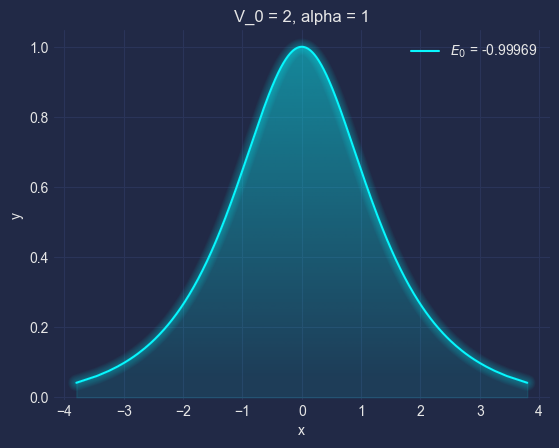

In [6]:
v_0 = 2
alpha_0 = 1

for idx, eigenVal in enumerate(eigen):
    x, y = getEigenFunc(v_0, alpha_0, eigenVal, idx, 5)
    plt.plot(x, [item[0] for item in y], label=f"$E_{idx}$ = {round(eigenVal, 5)}")
    plt.xlabel('x')
    plt.ylabel('y')

plt.title(f"V_0 = {v_0}, alpha = {alpha_0}")
plt.legend()
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)
plt.show()

# Раз уж реализовали, то можно построить тоже самое для других значений параметров ($\alpha = 2, V_0 = 99$):

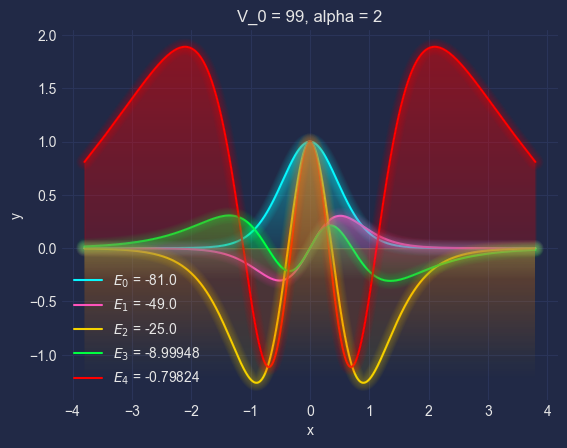

In [7]:
v_0 = 99
alpha_0 = 2

eigen = ShootingEigenShrodinger(v_0, alpha_0)

for idx, eigenVal in enumerate(eigen):
    x, y = getEigenFunc(v_0, alpha_0, eigenVal, idx, 5)
    plt.plot(x, [item[0] for item in y], label=f"$E_{idx}$ = {round(eigenVal, 5)}")
    plt.xlabel('x')
    plt.ylabel('y')

plt.title(f"V_0 = {v_0}, alpha = {alpha_0}")
plt.legend()
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)
plt.show()

# Реализовано по статье https://www1.itp.tu-berlin.de/brandes/public_html/qm/qv3.pdf